In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

print ( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# Build the dataset
block_size = 8 #Context length

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print ( ''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [7]:
class Linear:
    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
    
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [8]:
torch.manual_seed(42);

In [9]:
n_embed = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),    
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 

parameters = model.parameters()
print ( sum(p.nelement() for p in parameters) )
for p in parameters:
    p.requires_grad = True

22397


In [10]:
max_steps = 200 * 1000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 150*1000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3102
  10000/ 200000: 2.1976
  20000/ 200000: 2.2470
  30000/ 200000: 2.0972
  40000/ 200000: 2.0267
  50000/ 200000: 2.4313
  60000/ 200000: 2.0933
  70000/ 200000: 1.9335
  80000/ 200000: 2.1475
  90000/ 200000: 2.0503
 100000/ 200000: 1.7831
 110000/ 200000: 2.5270
 120000/ 200000: 2.6389
 130000/ 200000: 2.0499
 140000/ 200000: 2.2905
 150000/ 200000: 1.8648
 160000/ 200000: 2.0317
 170000/ 200000: 2.3145
 180000/ 200000: 2.0926
 190000/ 200000: 1.8594


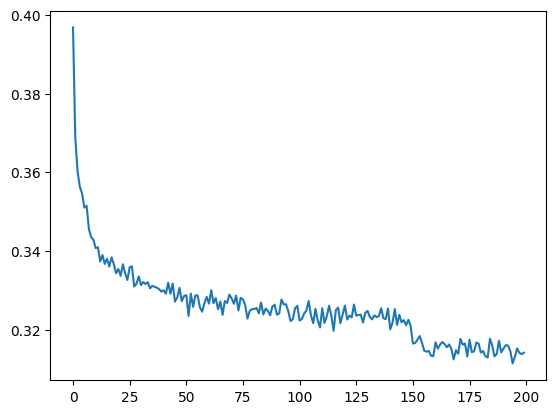

In [11]:
plt.plot( torch.tensor(lossi).view(-1,1000).mean(1) );

In [12]:
# Put layers into eval mode
for layer in model.layers:
    layer.training = False

In [13]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')
    

train 2.044834852218628
val 2.0878818035125732


In [14]:
# Sample from the mode

for _ in range(20):
    
    out = []
    context = [0]*block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print ( ''.join(itos[i] for i in out))

lansan.
dylina.
jenilia.
kailot.
benoletha.
elexte.
allie.
nailan.
reck.
melleo.
saqari.
frane.
zaryiak.
erishiel.
ennaha.
dhurahit.
lekquan.
lawheon.
darleigh.
reuid.


In [15]:
# https://youtu.be/t3YJ5hKiMQ0?t=1038